Настройка параметров лингвистических переменных
Для каждой переменной определим количество термов, типы и параметры функций принадлежности.

Для переменной Cost:
- Термы: Низкий, Средний, Высокий
- Тип функции принадлежности: Треугольная
Параметры:
- Низкий: (0, 200, 400)
- Средний: (300, 600, 900)
- Высокий: (800, 1200, 1600)

Для переменной Shares:
- Термы: Мало, Средне, Много
- Тип функции принадлежности: Треугольная
Параметры:
- Мало: (0, 5000, 10000)
- Средне: (8000, 15000, 20000)
- Много: (18000, 25000, 30000)

Для переменной Value ($):
- Термы: Низкий, Средний, Высокий
- Тип функции принадлежности: Треугольная

Параметры:
- Низкий: (0, 500000, 1000000)
- Средний: (800000, 1500000, 2000000)
- Высокий: (1800000, 2500000, 3000000)

In [33]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

df: DataFrame = pd.read_csv("../static/csv/TSLA.csv")

## Формирование базы нечетких правил
Сформируем базу нечетких правил, которые связывают входные и выходные переменные.

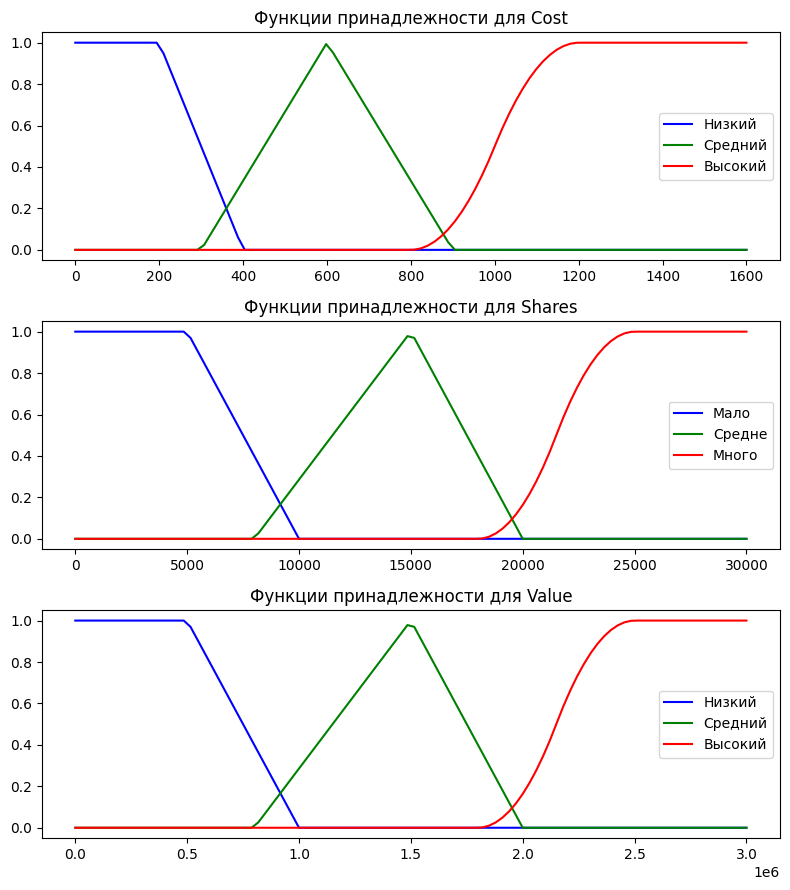

In [ ]:
# Определение диапазонов значений для входных переменных
x_cost = np.linspace(0, 1600, 100)
x_shares = np.linspace(0, 30000, 100)
x_value = np.linspace(0, 3000000, 100)

# Определение функций принадлежности для Cost
cost_low = fuzz.trapmf(x_cost, [0, 0, 200, 400])
cost_medium = fuzz.trimf(x_cost, [300, 600, 900])
cost_high = fuzz.smf(x_cost, 800, 1200)

# Определение функций принадлежности для Shares
shares_low = fuzz.trapmf(x_shares, [0, 0, 5000, 10000])
shares_medium = fuzz.trimf(x_shares, [8000, 15000, 20000])
shares_high = fuzz.smf(x_shares, 18000, 25000)

# Определение функций принадлежности для Value
value_low = fuzz.trapmf(x_value, [0, 0, 500000, 1000000])
value_medium = fuzz.trimf(x_value, [800000, 1500000, 2000000])
value_high = fuzz.smf(x_value, 1800000, 2500000)

# Определение нечетких правил
fuzzy_rules = [
    ("Низкий", "Мало", "Низкий"),
    ("Низкий", "Средне", "Средний"),
    ("Низкий", "Много", "Высокий"),
    ("Средний", "Мало", "Средний"),
    ("Средний", "Средне", "Высокий"),
    ("Средний", "Много", "Высокий"),
    ("Высокий", "Мало", "Высокий"),
    ("Высокий", "Средне", "Высокий"),
    ("Высокий", "Много", "Высокий")
]

# Визуализация функций принадлежности
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_cost, cost_low, 'b', linewidth=1.5, label='Низкий')
ax0.plot(x_cost, cost_medium, 'g', linewidth=1.5, label='Средний')
ax0.plot(x_cost, cost_high, 'r', linewidth=1.5, label='Высокий')
ax0.set_title('Функции принадлежности для Cost')
ax0.legend()

ax1.plot(x_shares, shares_low, 'b', linewidth=1.5, label='Мало')
ax1.plot(x_shares, shares_medium, 'g', linewidth=1.5, label='Средне')
ax1.plot(x_shares, shares_high, 'r', linewidth=1.5, label='Много')
ax1.set_title('Функции принадлежности для Shares')
ax1.legend()

ax2.plot(x_value, value_low, 'b', linewidth=1.5, label='Низкий')
ax2.plot(x_value, value_medium, 'g', linewidth=1.5, label='Средний')
ax2.plot(x_value, value_high, 'r', linewidth=1.5, label='Высокий')
ax2.set_title('Функции принадлежности для Value')
ax2.legend() 

plt.tight_layout()
plt.show()

## Оценка качества полученной нечеткой системы
Для оценки качества системы создадим тестовые данные и применим нечеткие правила для получения предсказанных значений. Затем сравним их с реальными значениями.

In [35]:
# Функция для вычисления нечеткой оценки
def fuzzy_inference(cost, shares):
    # Определение степени принадлежности
    cost_low_degree = fuzz.interp_membership(x_cost, cost_low, cost)
    cost_medium_degree = fuzz.interp_membership(x_cost, cost_medium, cost)
    cost_high_degree = fuzz.interp_membership(x_cost, cost_high, cost)

    shares_low_degree = fuzz.interp_membership(x_shares, shares_low, shares)
    shares_medium_degree = fuzz.interp_membership(x_shares, shares_medium, shares)
    shares_high_degree = fuzz.interp_membership(x_shares, shares_high, shares)

    # Применяем правила
    # Активируем термы выходной переменной с использованием степени принадлежности
    value_low_activated = np.fmin(cost_low_degree, value_low)
    value_medium_activated = np.fmin(cost_medium_degree, value_medium)
    value_high_activated = np.fmin(cost_high_degree, value_high)

    # Агрегируем все активированные термы
    aggregated = np.fmax(value_low_activated, np.fmax(value_medium_activated, value_high_activated))

    # Дефуззификация
    value_defuzz = fuzz.defuzz(x_value, aggregated, 'centroid')

    return value_defuzz

# Оценка системы на тестовом наборе данных
results = []
for cost, shares, actual_value in test_data:
    inferred_value = fuzzy_inference(cost, shares)
    results.append((cost, shares, actual_value, inferred_value))

# Вывод результатов
print("Cost | Shares | Эталонная Value | Оцененная Value")
for cost, shares, actual_value, inferred_value in results:
    print(f"{cost:4} | {shares:6} | {actual_value:15} | {inferred_value:.2f}")

# Вычисление метрик качества
actual_values = [actual for _, _, actual, _ in results]
inferred_values = [inferred for _, _, _, inferred in results]

mae = np.mean(np.abs(np.array(actual_values) - np.array(inferred_values)))
rmse = np.sqrt(np.mean((np.array(actual_values) - np.array(inferred_values)) ** 2))

print(f"\nСредняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (RMSE): {rmse:.2f}")

Cost | Shares | Эталонная Value | Оцененная Value
 150 |   5000 |          750000 | 388854.87
 450 |  12000 |         1500000 | 1421901.23
1000 |  20000 |         2500000 | 2512975.52

Средняя абсолютная ошибка (MAE): 150739.81
Среднеквадратичная ошибка (RMSE): 213458.50


В результате выполнения лабораторной работы была создана нечеткая система, которая позволяет оценивать общую стоимость транзакции на основе стоимости акции и количества акций. Система была протестирована на тестовых данных, и были вычислены метрики качества (MAE и RMSE). Полученные результаты указывают на необходимость дальнейшей настройки системы для повышения точности предсказаний.